Import library

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from data_loader import TrainDatasetFolder
import matplotlib.pyplot as plt


backbone of the module: U-Net


In [4]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""

    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[..., None, None]

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  Returns:
  
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(6, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False,output_padding=1)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False,
                                         output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False,
                                         output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 6, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

        self.channels = channels

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))
        # Encoding path
        frame,c,xi,yi = x.shape
        h1 = nn.Conv2d(c, self.channels[0], 3, stride=1, bias=False)(x)
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)


        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)
        # Decoding path
        h = self.tconv4(h4)

        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))

        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = nn.ConvTranspose2d(self.channels[0] + self.channels[0], c, 3, stride=1)(torch.cat([h, h1], dim=1))
        # h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h


In [7]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
    
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss
    


Visualize the data:


show as gif

In [4]:
def r2c(x, axis=1):
    """Convert pseudo-complex data (2 real channels) to complex data

    x: ndarray
        input data
    axis: int
        the axis that is used to represent the real and complex channel.
        e.g. if axis == i, then x.shape looks like (n_1, n_2, ..., n_i-1, 2, n_i+1, ..., nm)
    """
    x_real = x[:,0,...]
    x_img = x[:,1,...]
    x = x_real + 1j*x_img
    x = np.transpose(x,[3,0,1,2])

    return x

def from_tensor_format(x):
    x = r2c(x)
    return x


In [5]:
from IPython.display import display, Image, HTML
from matplotlib.animation import FuncAnimation
from k_space import ifft2c, fft2c
import seaborn as sns
#note that this fft and ifft only do fft in the last 2 axis of image!!!

def save_show_gif(img_frames, gif_path):
    plt.ioff()
    fig, ax = plt.subplots()
    im = ax.imshow(img_frames[0], cmap='gray', animated=True)
    def update(frame):
        im.set_array(img_frames[frame])
        return im,
    animation = FuncAnimation(fig, update, frames=len(img_frames), interval=100, blit=True)
    animation.save(gif_path, writer='pillow', fps=10)
    display(HTML(animation.to_jshtml()))
    # with open(gif_path, 'rb') as f:
    #     display(Image(data=f.read()))

3.1415917759003786 -3.1415920621831392 pi
sax_P118_k2_full_crop


sax_P118_k2_full_crop


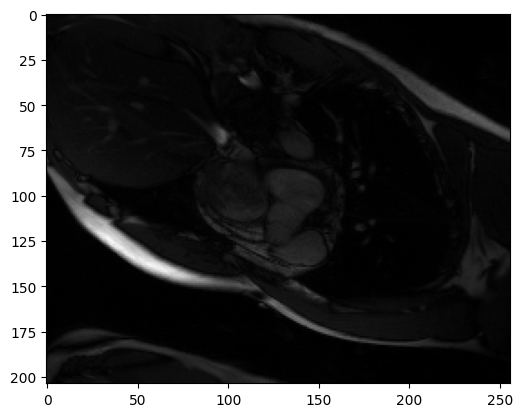

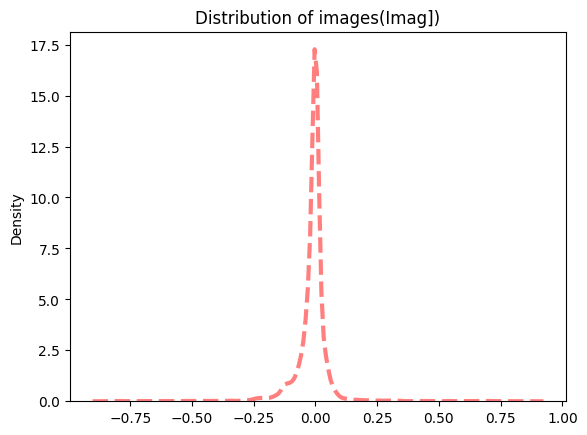

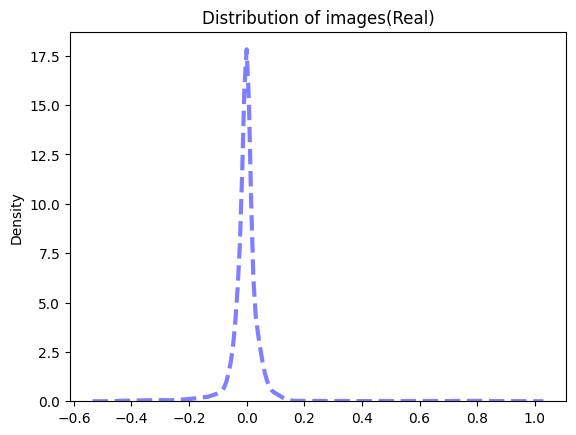

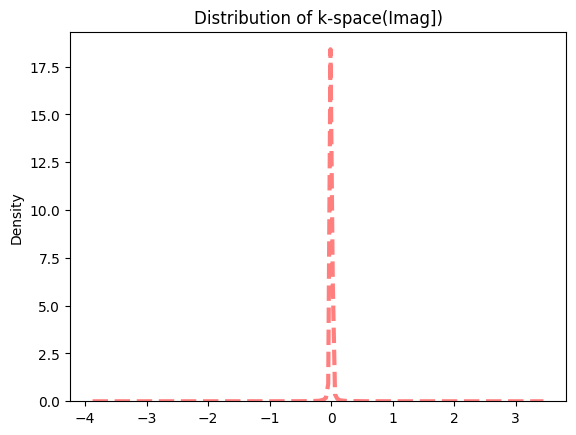

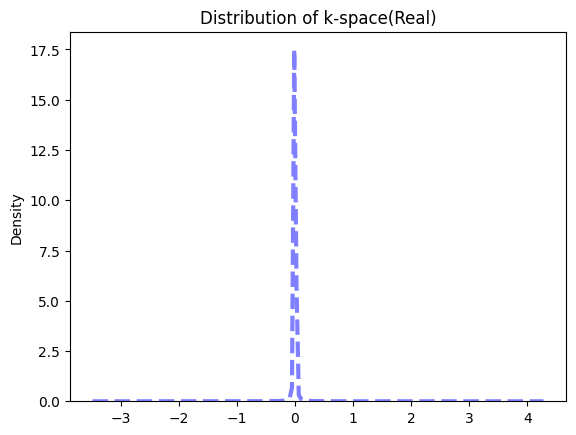

In [9]:
Train_data = TrainDatasetFolder('04','sax',False)
k_und, im_und, im_gnd, mask = Train_data[1]
im_gnd = from_tensor_format(im_gnd)
print(np.angle(im_gnd).max(),np.angle(im_gnd).min(),'pi')

img_frames = []
for i in range(im_gnd.shape[0]):
    im = np.array(abs(im_gnd[i,0,...]))
    img_frames.append(im)
gif_path = '/home/zhenlin/SDEs/sax_P118_full_k2_crop.gif'
print('sax_P118_k2_full_crop')
save_show_gif(img_frames, gif_path)



k_gnd = fft2c(im_gnd)
img_frames = []
for i in range(k_gnd.shape[0]):
    im = np.array(abs(k_gnd[i,0,...]))
    img_frames.append(im)
gif_path = '/home/zhenlin/SDEs/sax_P118_full_k2_crop.gif'
print('sax_P118_k2_full_crop')
save_show_gif(img_frames, gif_path)

plt.clf()
# plt.ioff()
plt.title("Distribution of images(Imag])")
ax = sns.kdeplot(np.imag(im_gnd[0,0,...].flatten()), color="red", alpha=0.5, ls="--", lw=3)
plt.show()

plt.clf()
plt.title("Distribution of images(Real)")
ax = sns.kdeplot(np.real(im_gnd[0,0,...].flatten()), color="blue", alpha=0.5, ls="--", lw=3)
plt.show()

plt.clf()
plt.title("Distribution of k-space(Imag])")
ax = sns.kdeplot(np.imag(k_gnd[0,0,...].flatten()), color="red", alpha=0.5, ls="--", lw=3)
plt.show()

plt.clf()
plt.title("Distribution of k-space(Real)")
ax = sns.kdeplot(np.real(k_gnd[0,0,...].flatten()), color="blue", alpha=0.5, ls="--", lw=3)
plt.show()

#Org image size:[12, 10, 204, 512] (t,s,x,y)
#image from loader size:[10, 2, 204, 256, 12] (s,c,x,y,t)

In [10]:
import h5py
def load_mat(file_path:str):
    with h5py.File(file_path, 'r') as f:
        key0 = list(f.keys())[0]

        assert len(list(f.keys())) == 1, "There is more than 1 key in the mat file."
        try:
            dataset = f[key0][:]
        except KeyError:
            print(f'Key Error, options:{f.keys()}')
    if dataset.ndim > 3:
        dataset = dataset["real"] + 1j*dataset["imag"]
    return dataset

original_k_path = '/home/zhenlin/CMRxRecon2023/dataset/SingleCoil/Cine/TrainingSet/FullSample/P118/cine_sax.mat'
original_k = load_mat(original_k_path)
img_frames = []
for i in range(original_k.shape[0]):
    original_image_frame = abs(original_k[i,0,...])
    img_frames.append(original_image_frame)
gif_path = '/home/zhenlin/SDEs/sax_P118_Full_org_k.gif'
print('sax_P118_k_space_04')
save_show_gif(img_frames, gif_path)

original_image = ifft2c(original_k)
print(original_image.shape)
img_frames = []
for i in range(original_image.shape[0]):

    original_image_frame = abs(original_image[i,0,...])
    img_frames.append(original_image_frame)
gif_path = '/home/zhenlin/SDEs/sax_P01_Full_org.gif'
print('sax_P118_image_full')
save_show_gif(img_frames, gif_path)

sax_P118_k_space_04


(12, 10, 204, 512)
sax_P118_image_full


Visualize from slice:

In [11]:
img_frames = []
for i in range(original_image.shape[1]):
    im_gnd_np = np.array(abs(original_image[0,i,...]))
    img_frames.append(im_gnd_np)
gif_path = '/home/zhenlin/SDEs/lax_P01_Full_slice.gif'
save_show_gif(img_frames, gif_path)

In [ ]:
v_data = TrainDatasetFolder('08','lax',False)
k_und, im_und, im_gnd, mask = v_data[0]
im_gnd = from_tensor_format(im_gnd)
print(im_gnd.shape)
img_frames = []
for i in range(im_gnd.shape[0]):
    im_gnd_np = np.array(abs(im_gnd[i,0,...]))
    img_frames.append(im_gnd_np)
gif_path = '/home/zhenlin/SDEs/lax_P01_Full.gif'
save_show_gif(img_frames, gif_path)

plt.clf()
plt.ioff()
plt.title("Distribution of images(Mag])")
ax = sns.kdeplot(np.abs(im_gnd[0,0,...].flatten()), color="red", alpha=0.5, ls="--", lw=3)
plt.show()



im_und = from_tensor_format(im_und)
img_frames = []
for i in range(im_gnd.shape[0]):
    im_und_np = np.array(abs(im_und[i,0,...]))
    img_frames.append(im_und_np)
gif_path = '/home/zhenlin/SDEs/lax_P01_08.gif'
save_show_gif(img_frames, gif_path)
plt.clf()
plt.ioff()
plt.title("Distribution of images(Mag])")
ax = sns.kdeplot(np.abs(im_und[0,0,...].flatten()), color="red", alpha=0.5, ls="--", lw=3)
plt.show()


Visualize in k-space:

In [12]:
original_k_path = '/home/zhenlin/CMRxRecon2023/dataset/SingleCoil/Cine/TrainingSet/FullSample/P024/cine_lax.mat'
original_k = load_mat(original_k_path)
print(original_k.shape)
img_frames = []
for i in range(original_k.shape[0]):
    original_k1 = np.array(abs(original_k[i,0,...]))
    img_frames.append(original_k1)
gif_path = '/home/zhenlin/SDEs/lax_P01_Full_k_uncrop.gif'
save_show_gif(img_frames, gif_path)

(12, 3, 168, 448)


# perturb data with niose
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}

In [5]:
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
    
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  

  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

## adding niose to data

In [9]:
eps = 1e-5
random_t = torch.rand(im_gnd.shape[0], device=im_gnd.device) * (1. - eps) + eps  
print('time:',random_t) 
random_t = [0.001, 0.01, 0.1]
z = torch.randn_like(im_gnd[0, 0,...])
print(z.shape)
std = marginal_prob_std(random_t,sigma = 25)
print('std:',std)
perturbed_x = im_gnd + z[None, None,...]*std[None,:,None,None]
print(perturbed_x, perturbed_x.shape)
img_frames = []
for i in range(perturbed_x.shape[0]):
    original_k1 = np.array(abs(perturbed_x[i,0,...]))
    img_frames.append(original_k1)
gif_path = '/home/zhenlin/SDEs/lax_P024_perturbed_x.gif'
save_show_gif(img_frames, gif_path)
img_frames = []
for i in range(perturbed_x.shape[0]):
    original_k1 = np.array(abs(perturbed_x[i,1,...]))
    img_frames.append(original_k1)
gif_path = '/home/zhenlin/SDEs/lax_P024_perturbed_x.gif'
save_show_gif(img_frames, gif_path)
img_frames = []
for i in range(perturbed_x.shape[0]):
    original_k1 = np.array(abs(perturbed_x[i,2,...]))
    img_frames.append(original_k1)
gif_path = '/home/zhenlin/SDEs/lax_P024_perturbed_x.gif'
save_show_gif(img_frames, gif_path)

plt.clf()
plt.ioff()
plt.title("Distribution of images(Real])")
ax = sns.kdeplot(perturbed_x[0,2,...].flatten(), color="red", alpha=0.5, ls="--", lw=3)
sns.kdeplot(z.flatten(), color="blue", ax=ax, alpha=0.5, ls="--", lw=3)
sns.kdeplot(im_gnd[0, 0,...].flatten(), color="green", ax=ax, alpha=0.5, ls="--", lw=3)
plt.show()

time: tensor([0.5153, 0.9787, 0.2873, 0.3126, 0.6597, 0.8836, 0.1867, 0.6214, 0.2133,
        0.8778, 0.9785, 0.4837])
torch.Size([128, 128])
std: tensor([0.0317, 0.1016, 0.3747])


RuntimeError: The size of tensor a (6) must match the size of tensor b (3) at non-singleton dimension 1

# training

In [11]:
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import tqdm


score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
ckpt = torch.load('model_para/ckpt_299.pth')
score_model.load_state_dict(ckpt)

n_epochs =   100
lr=1e-4 
random_crop = transforms.RandomCrop(128)

Train_data = TrainDatasetFolder('04','lax',False)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  patient_num = len(Train_data.patient)
  for i in range(patient_num):
    k_und, im_und, im_gnd, mask = Train_data[i]
    s,c,x,y,t = im_gnd.shape
    im_gnd = im_gnd.reshape(t,s*c,x,y).to(device)
    im_gnd = random_crop(im_gnd)
    im_gnd = im_gnd.float().to(device)    
    loss = loss_fn(score_model, im_gnd, marginal_prob_std_fn)
    print(loss)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * im_gnd.shape[0]
    num_items += im_gnd.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'model_para/ckpt_08_{}.pth'.format(epoch))


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_2376566/3456366414.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


tensor(98471.7500, grad_fn=<MeanBackward0>)
tensor(99563.1953, grad_fn=<MeanBackward0>)
tensor(99373.9766, grad_fn=<MeanBackward0>)
tensor(99498.6250, grad_fn=<MeanBackward0>)
tensor(99819.7500, grad_fn=<MeanBackward0>)
tensor(65760.4453, grad_fn=<MeanBackward0>)
tensor(66509.4766, grad_fn=<MeanBackward0>)
tensor(99393.8984, grad_fn=<MeanBackward0>)
tensor(98932.4922, grad_fn=<MeanBackward0>)
tensor(98891.1562, grad_fn=<MeanBackward0>)
tensor(98977.4375, grad_fn=<MeanBackward0>)
tensor(99597.7188, grad_fn=<MeanBackward0>)
tensor(98952.6484, grad_fn=<MeanBackward0>)
tensor(98931.7422, grad_fn=<MeanBackward0>)
tensor(99277.6875, grad_fn=<MeanBackward0>)
tensor(99444.4609, grad_fn=<MeanBackward0>)
tensor(99739., grad_fn=<MeanBackward0>)
tensor(99444.4766, grad_fn=<MeanBackward0>)
tensor(99454.6875, grad_fn=<MeanBackward0>)
tensor(99509.7891, grad_fn=<MeanBackward0>)
tensor(99348.9922, grad_fn=<MeanBackward0>)
tensor(99853.8516, grad_fn=<MeanBackward0>)
tensor(99851.0312, grad_fn=<MeanBack

## sample
The reverse-time SDE is given by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + \sigma^t d \bar{\mathbf{w}}.
\end{align*}

In [ ]:
num_steps =  200
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=1, 
                           num_steps=num_steps, 
                           device='cpu', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 128, 128, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x

  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x


from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('model_para/ckpt_299.pth', map_location=device)
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
score_model.load_state_dict(ckpt)

sample_batch_size = 16
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/tmp/ipykernel_2376566/3456366414.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


NameError: name 'tqdm' is not defined

## try to decompose the image

In [ ]:
t,s,x,y = im_gnd.shape
print(t,s,x,y)
base_frame = int(t/2)
print(base_frame)
base_image = im_gnd[base_frame:base_frame+1,0,...]
print(base_image.shape)
decomposed_frame = []
for i in range(im_gnd.shape[0]):
    residual = abs(im_gnd[i,0,...])-abs(base_image)
    residual = residual[0,...]
    decomposed_frame.append(residual)
gif_path = '/home/zhenlin/SDEs/lax_P024_decomp.gif'
save_show_gif(decomposed_frame, gif_path)

#imporveing diffusion
fisrt few steps contribute more